## __Step 3:__ Dimension Reduction & Structural Preservation Analysis

In [1]:
import QCPipe # contains code necessary for distance preservation analysis, including scanpy and related functions
import scanpy as sc 
import numpy as np

In [2]:
sc.settings.verbosity = 3 #Set scanpy verbosity to 3 for in depth function run information

In [3]:
import random
random.seed(56)

---
### __3.1__ Preprocessing & Dimension Reduction with `scanpy`

[`AnnData`](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html) objects can be read straight from a compressed `.h5ad` file, containing metadata and reduced dimensions.

Here, we will read in a manually-filtered `.h5ad` file for our human colonic mucosa data.

In [4]:
adata = sc.read("Filtered_TNP_Data.h5ad") ; adata

AnnData object with n_obs × n_vars = 2176 × 29426

Now we can calculate some QC metrics and preprocess the raw counts by __normalizing per cell__ and __arcsinh-transforming__.

In [5]:
# get useful metrics of counts data
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
adata.layers["raw_counts"] = adata.X.copy()  # save raw counts in layer
QCPipe.fcc.arcsinh(adata, layer="raw_counts", norm="l1", scale=1000)  # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
adata.X = adata.layers["arcsinh_norm"].copy()  # set normalized counts as .X slot in scanpy object

# since we prefer arcsinh over log1p, let's get some arcsinh-transformed metrics as well
adata.obs["arcsinh_total_counts"] = np.arcsinh(adata.obs["total_counts"])
adata.obs["arcsinh_n_genes_by_counts"] = np.arcsinh(adata.obs["n_genes_by_counts"])

# see resulting AnnData contents
adata

AnnData object with n_obs × n_vars = 2176 × 29426
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'arcsinh_total_counts', 'arcsinh_n_genes_by_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

We can use `sc.pp.highly_variable_genes` to identify HVGs in our dataset to be used for PCA and downstream analysis.

In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Now we can perform an initial dimension reduction with __principal component analysis__. This dimension-reduced __native space__ will be used to generate further low-dimensional projections with __t-SNE__ and __UMAP__ (__latent spaces__), becoming the reference for our data structure preservation analysis.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


/home/bob/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


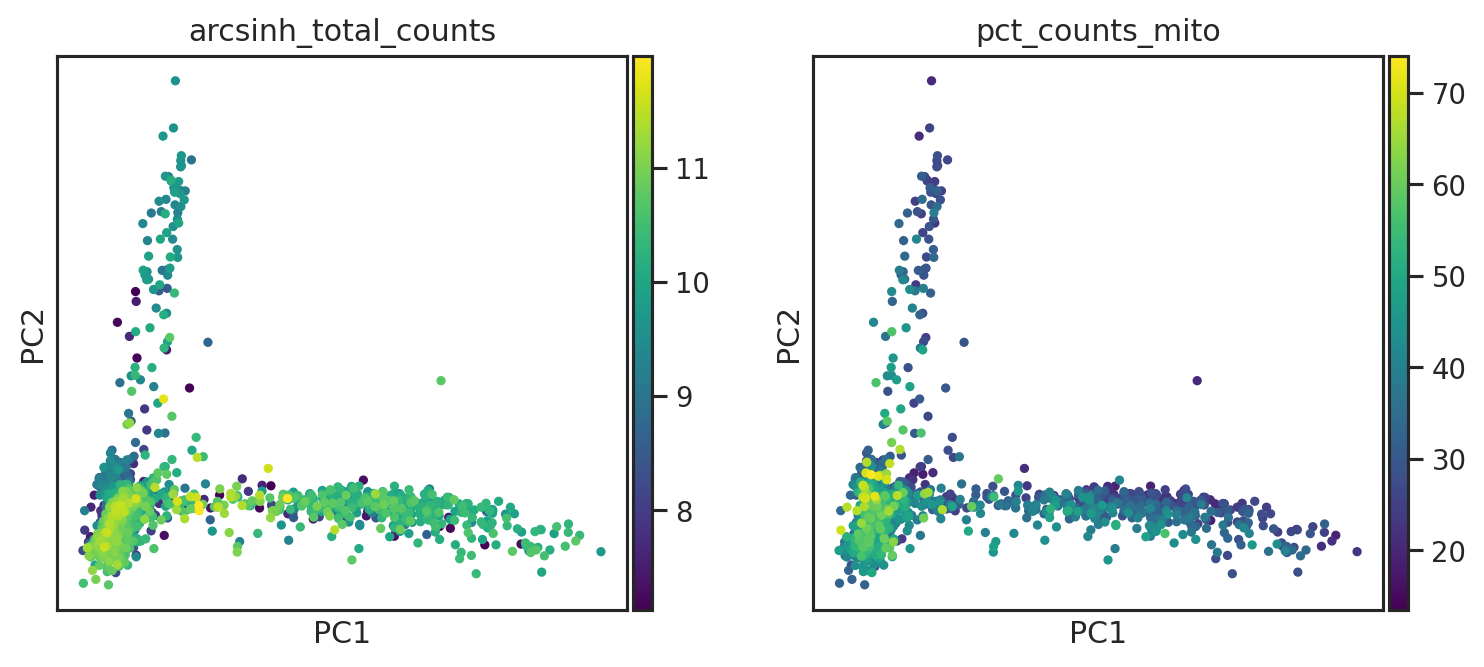

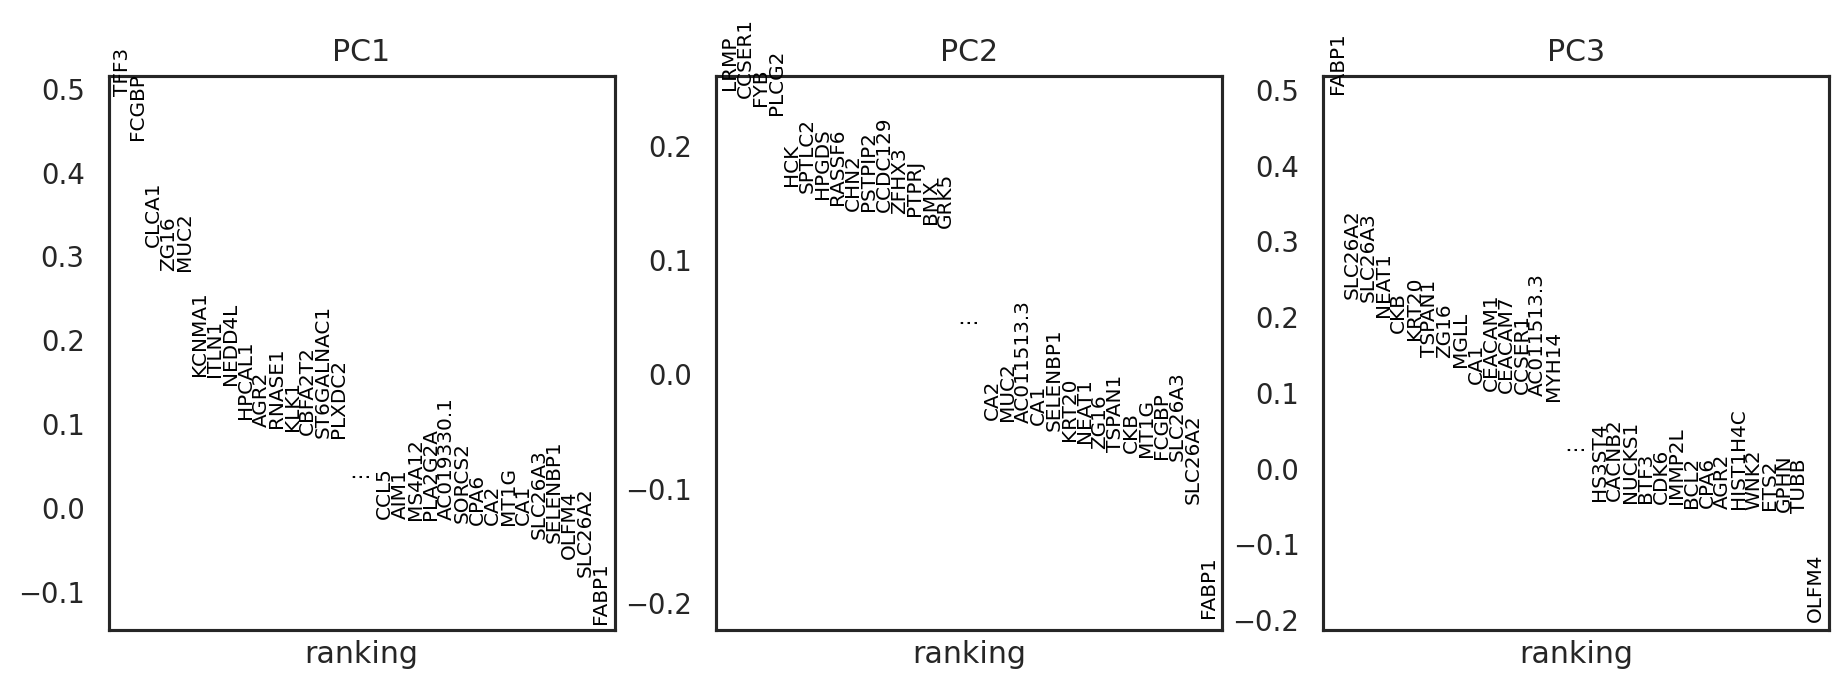

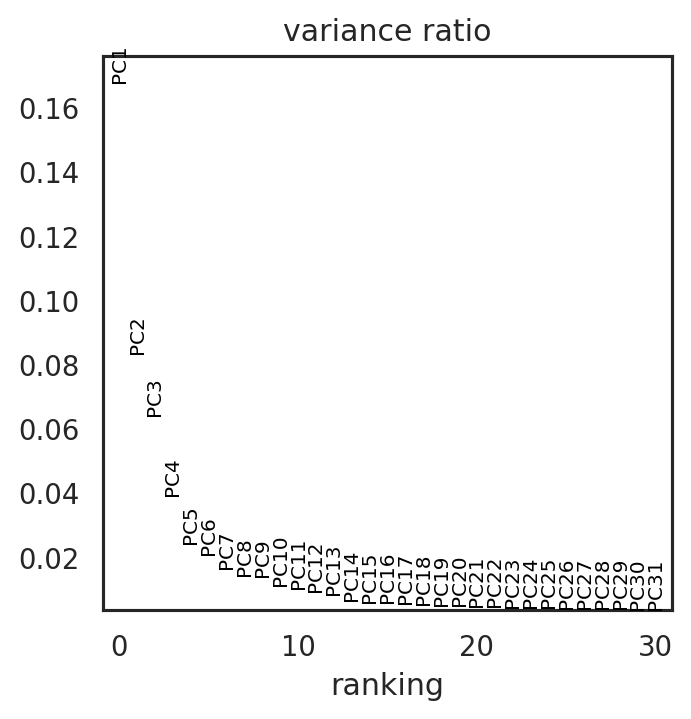

In [7]:
sc.tl.pca(adata, n_comps=50,random_state=1)  # perform 50-component PCA on our feature-selected dataset
sc.pl.pca_overview(adata, color=["arcsinh_total_counts","pct_counts_mito"], color_map="viridis")  # view first two PCs, feature loadings, and variance

Next, we'll generate a __k-nearest neighbors (kNN)__ graph that describes similarity between all cells in our dataset based on the above 50 PCs. This graph will be used to perform unsupervised clustering and eventually generate a __UMAP__ embedding.

We choose the optimal number of nearest neighbors for graph building and __t-SNE__ analysis (perplexity) as the square-root of the total number of cells:

In [8]:
n_neighbs = int(np.sqrt(adata.n_obs))  # determine optimal number of neighbors by sqrt(n_obs)
print("Number of nearest neighbors: {}".format(n_neighbs))

Number of nearest neighbors: 46


Using the __PCA__ output above, we can generate a kNN graph and then perform graph-based __Leiden__ clustering to determine subpopulations.

In [9]:
sc.pp.neighbors(adata, n_neighbors=n_neighbs, n_pcs=50, random_state=1)  # generate kNN graph
sc.tl.leiden(adata, resolution=2, random_state=1)  # determine dataset clusters

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Now we can perform our favorite two-dimensional embeddings for dataset visualization.

---
### __3.2__ t-SNE Embedding

Let's start with __t-SNE__, using the optimal `n_neighbs` value as the __perplexity__ parameter and beginning with all 50 principal components.

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:09)


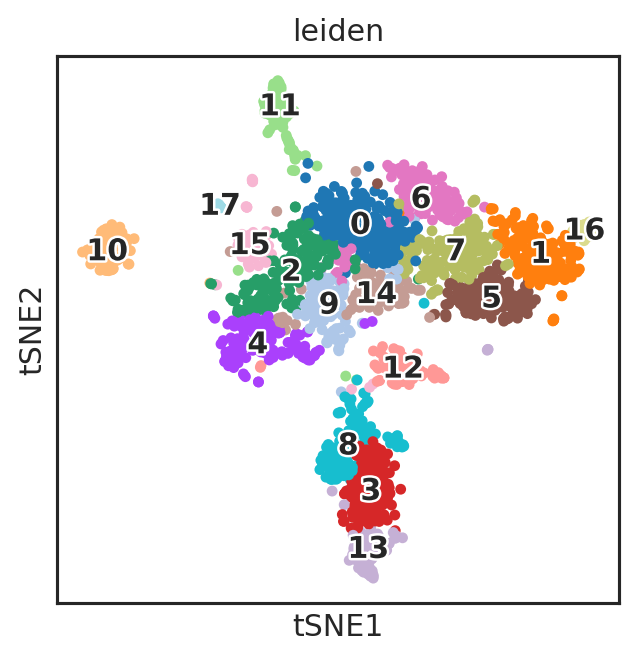

In [10]:
sc.tl.tsne(adata, use_rep="X_pca", perplexity=n_neighbs, random_state=1)  # generate t-SNE coordinates
sc.pl.tsne(adata, color="leiden", legend_loc="on data", legend_fontsize=12, legend_fontoutline=2, size=75, save="_leiden.png")  # plot t-SNE with Leiden cluster overlay

---
### __3.3__ PAGA

Next, we'll use **PAGA** to generate a coarse-grained graph based on the **Leiden** clusters identified for our dataset. This will be useful in generating initial positions for our __UMAP__ embedding, resulting in faster and more reliable optimization than random initialization.

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


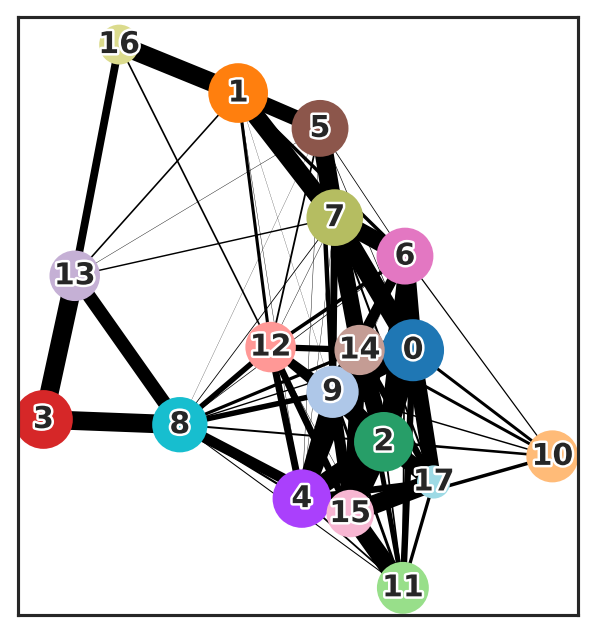

In [11]:
sc.tl.paga(adata)  # PAGA uses the kNN graph and Leiden clusters to create a cluster-cluster similarity graph
sc.pl.paga(adata, node_size_scale=3, fontsize=12, fontoutline=2, save=".png")  # plot PAGA graph. Edge thickness and distance describe cluster similarity

Now, we can use **PAGA** positions and the kNN graph generated from 50 principal components to build a two-dimensional **UMAP** embedding.

---
### __3.4__ UMAP Embedding

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


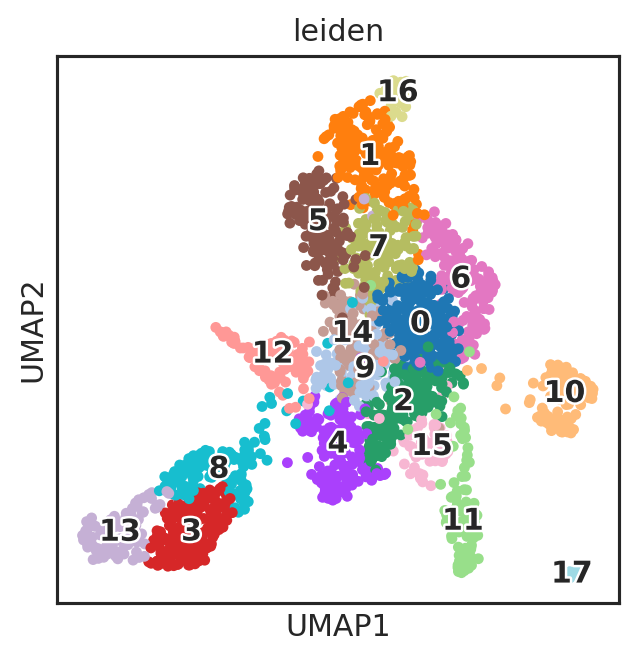

In [12]:
sc.tl.umap(adata, init_pos="paga",random_state=1)  # initialize UMAP with PAGA coordinates
sc.pl.umap(adata, color="leiden", legend_loc="on data", legend_fontsize=12, legend_fontoutline=2, size=75, save="_leiden.png")  # plot embedding with Leiden cluster overlay

---
### __3.5__ Global Structure Preservation Analysis

In order to determine which of our low-dimensional projections (__t-SNE__ or __UMAP__) does a better job of preserving global data structure for our dataset, we can apply the `scipy.spatial.distance.cdist()` function to different parts of our `AnnData` object to get symmetric distance matrices between all cells in the dataset across multiple low-dimensional latent spaces.

Functions sourced from [`fcc_utils.py`](fcc_utils.py).

In [13]:
%%time
# save distance matrix in AnnData object for easy access
adata.uns["X_pca_distances"] = QCPipe.fcc.cdist(adata.obsm["X_pca"], adata.obsm["X_pca"])
adata.uns["X_tsne_distances"] = QCPipe.fcc.cdist(adata.obsm["X_tsne"], adata.obsm["X_tsne"])

# calculate simple binary knn graph from the distance matrix above
QCPipe.fcc.knn_graph(adata.uns["X_pca_distances"], k=n_neighbs, adata=adata, save_rep="pca_knn")
QCPipe.fcc.knn_graph(adata.uns["X_tsne_distances"], k=n_neighbs, adata=adata, save_rep="tsne_knn")

CPU times: user 47.1 s, sys: 206 ms, total: 47.3 s
Wall time: 1.81 s


Using our `distance_stats` function, we can calculate structural preservation metrics between _latent_ __t-SNE__ space and its corresponding _native_ __PCA__ space.  

In [14]:
%time pca_dist, tsne_dist, corr_stats, EMD = QCPipe.fcc.distance_stats(pre=adata.uns["X_pca_distances"], post=adata.uns["X_tsne_distances"])
knn = QCPipe.fcc.knn_preservation(pre=adata.uns["pca_knn"]["graph"], post=adata.uns["tsne_knn"]["graph"])
print("\nR: {}\nEMD: {}\nKnn Pres. (%): {}".format(round(corr_stats[0],4), round(EMD,4), round(knn, 4)))

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
CPU times: user 2.22 s, sys: 4.13 s, total: 6.35 s
Wall time: 1.02 s

R: 0.6242
EMD: 0.1527
Knn Pres. (%): 97.5972


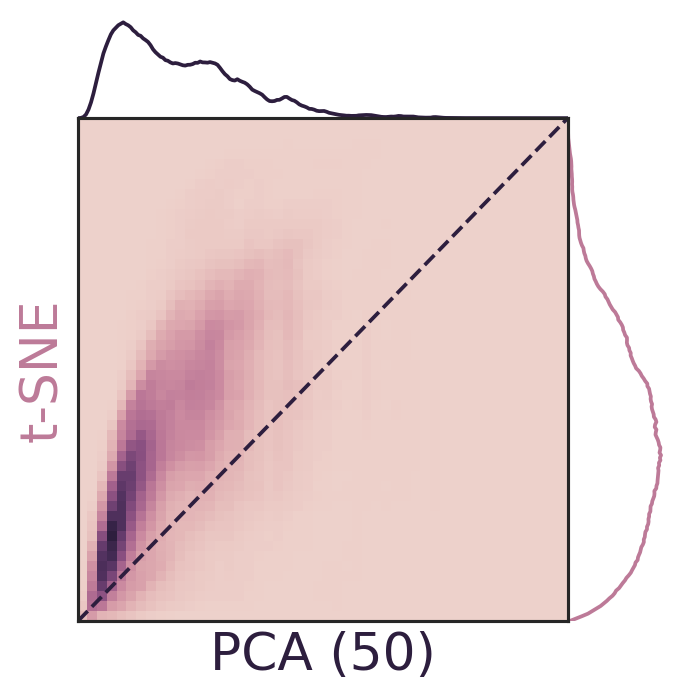

In [15]:
QCPipe.fcc.SP_plot(pre_norm=pca_dist, post_norm=tsne_dist, labels=["PCA (50)","t-SNE"]).joint_plot_distance_correlation(save_to="figures/tsne_joint.png")

You can also look at the normalized cumulative distance distributions in each projection and calculate the __Wasserstein metric__ or __Earth Mover's Distance__ between the two.

EMD: 0.1527


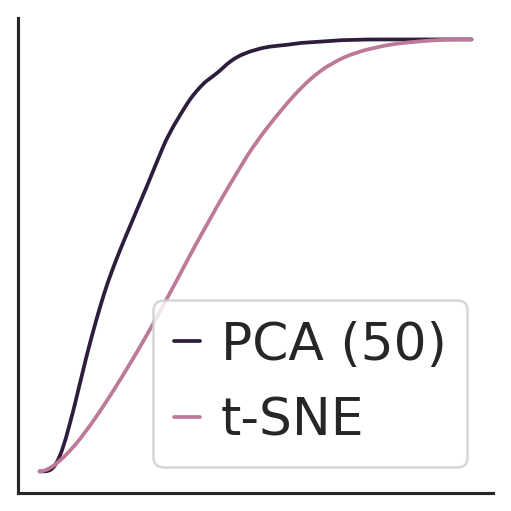

In [16]:
QCPipe.fcc.SP_plot(pre_norm=pca_dist, post_norm=tsne_dist, labels=["PCA (50)","t-SNE"], figsize=(3,3)).plot_cumulative_distributions(save_to="figures/tsne_dist.png")
print("EMD: {}".format(round(EMD,4)))

__AND__ if we want to do this all very quickly, there's a wrapper function for `AnnData` objects so you don't have to manually calculate and save distance matrices as above.  
Let's do this for our __UMAP__ calculations.

Calculating unique distances for latent space, X_umap
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
46-nearest neighbor calculation for native space, X_pca
46-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation
Done!
CPU times: user 45.1 s, sys: 3.05 s, total: 48.2 s
Wall time: 2.9 s

R: 0.6602
EMD: 0.1365
Knn Pres.: 97.5323


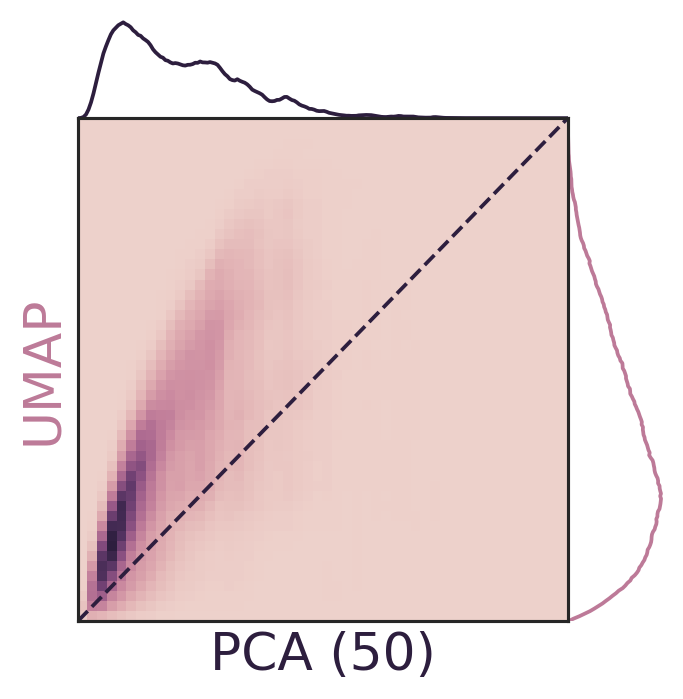

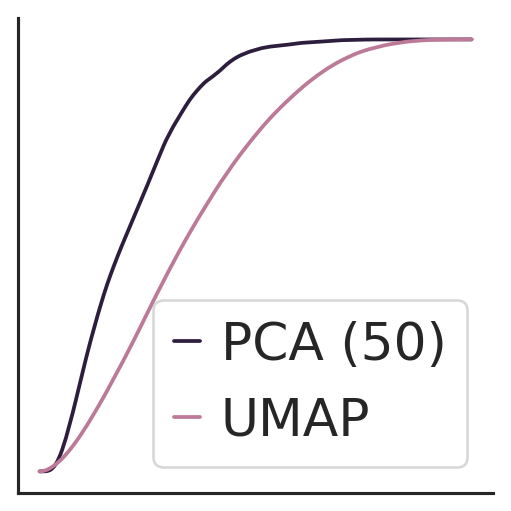

In [17]:
%time corr, EMD, knn = QCPipe.fcc.structure_preservation_sc(adata=adata, latent="X_umap", native="X_pca", k=n_neighbs)
print("\nR: {}\nEMD: {}\nKnn Pres.: {}".format(round(corr[0],4), round(EMD,4), round(knn, 4)))
QCPipe.fcc.SP_plot(pre_norm=adata.uns["X_pca_norm_distances"], post_norm=adata.uns["X_umap_norm_distances"], labels=["PCA (50)","UMAP"]).joint_plot_distance_correlation(save_to="figures/umap_joint.png")
QCPipe.fcc.SP_plot(pre_norm=adata.uns["X_pca_norm_distances"], post_norm=adata.uns["X_umap_norm_distances"], labels=["PCA (50)","UMAP"], figsize=(3,3)).plot_cumulative_distributions(save_to="figures/umap_dist.png")

---
### __3.6__ Differential Expression and Cell Type Inference

To identify cell types, let's perform __differential expression__ analysis and look at top genes in each cluster.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


/home/bob/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


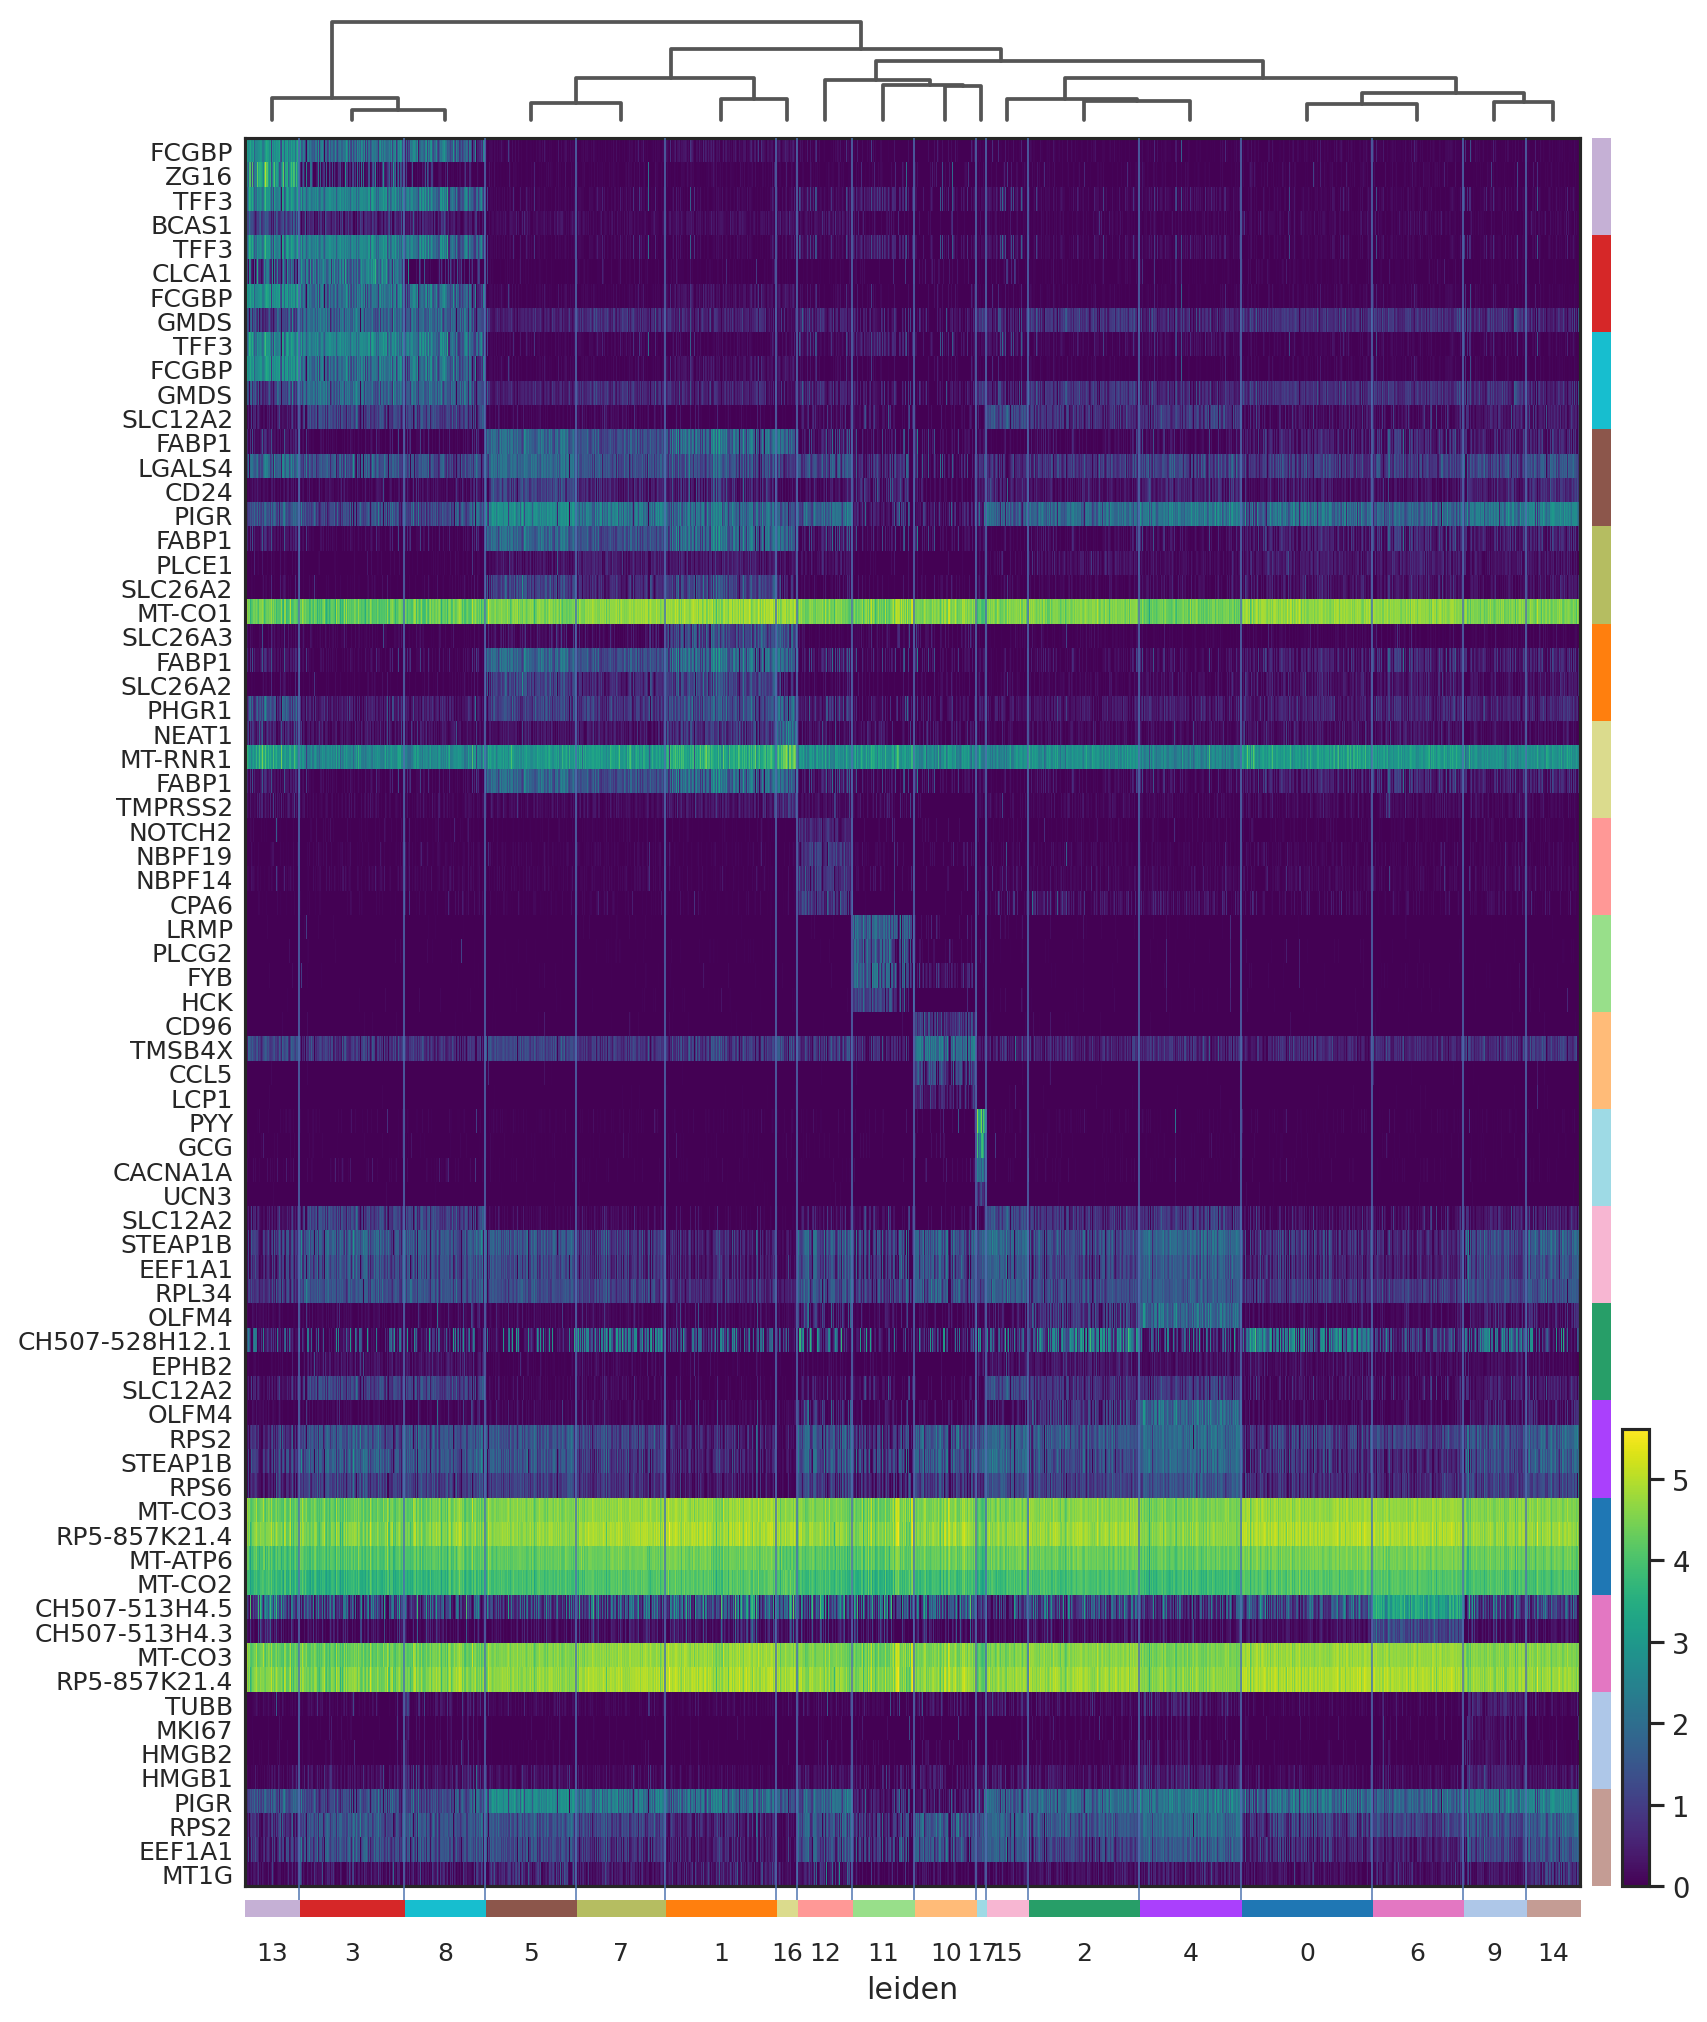

In [18]:
sc.tl.rank_genes_groups(adata, groupby="leiden")
sc.pl.rank_genes_groups_heatmap(adata, n_genes=4, cmap="viridis", swap_axes=True, show_gene_labels=True, save=".png")

---
### __3.7__ Local Structure Preservation Analysis

Now we can look at _local_ data structure within a given cluster of interest. Let's test the structural preservation of __tuft cell cluster "11"__.

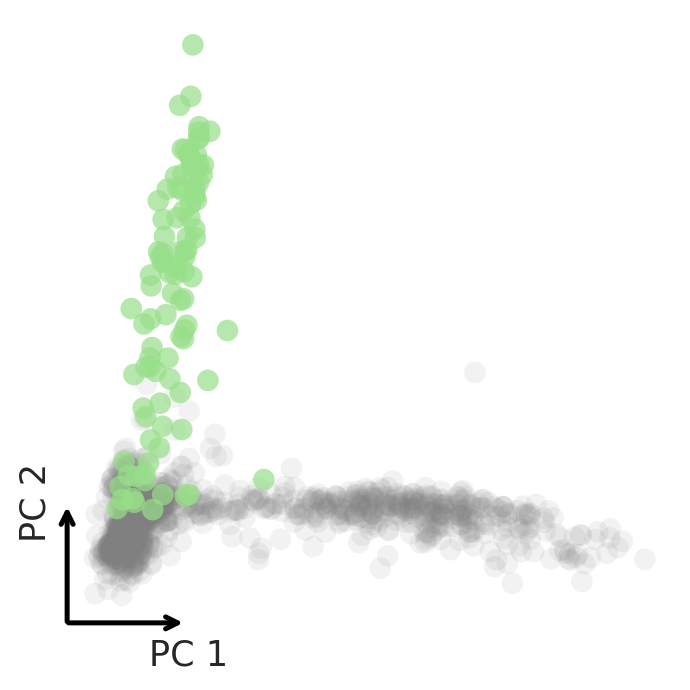

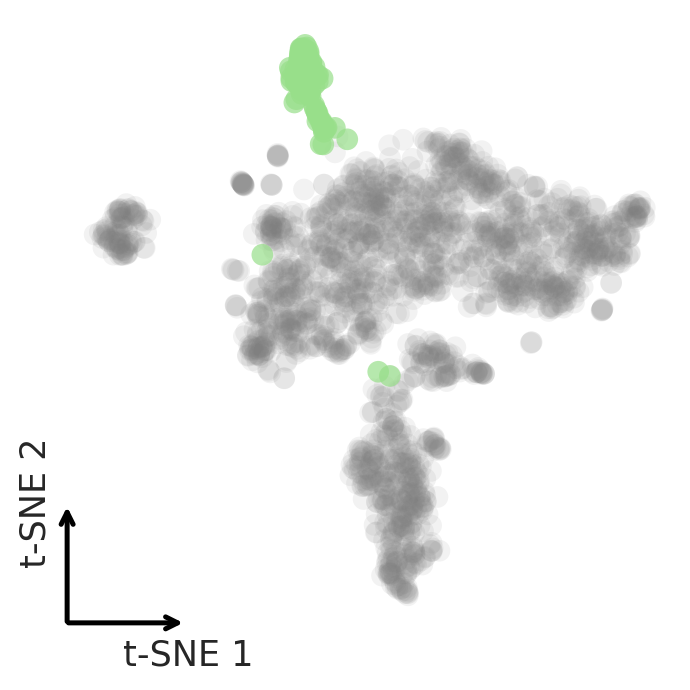

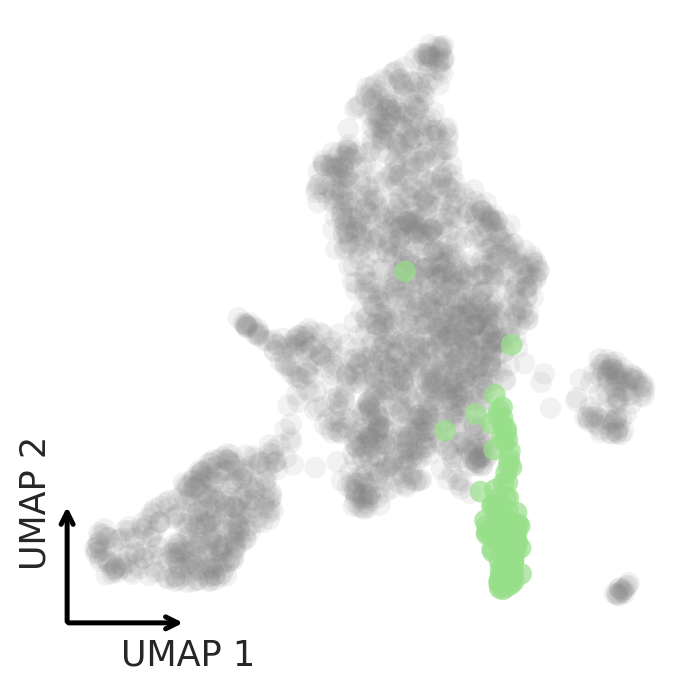

In [19]:
QCPipe.fcc.DR_plot(dim_name="PC", figsize=(4,4)).plot_IDs(adata=adata, use_rep="X_pca", obs_col="leiden", IDs=["11"], save_to="figures/pca_tuft.png")
QCPipe.fcc.DR_plot(dim_name="t-SNE", figsize=(4,4)).plot_IDs(adata=adata, use_rep="X_tsne", obs_col="leiden", IDs=["11"], save_to="figures/tsne_tuft.png")
QCPipe.fcc.DR_plot(dim_name="UMAP", figsize=(4,4)).plot_IDs(adata=adata, use_rep="X_umap", obs_col="leiden", IDs=["11"], save_to="figures/umap_tuft.png")

We can subset our distance matrices by `adata.obs['leiden']` and calculate structural preservation metrics as before

In [20]:
QCPipe.fcc.subset_uns_by_ID(
    adata, 
    uns_keys=["X_pca_distances","X_tsne_distances","X_umap_distances"], 
    obs_col="leiden", 
    IDs=["11"]
)

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions

R: 0.2498
EMD: 0.1565
CPU times: user 1.72 s, sys: 475 ms, total: 2.2 s
Wall time: 1.69 s


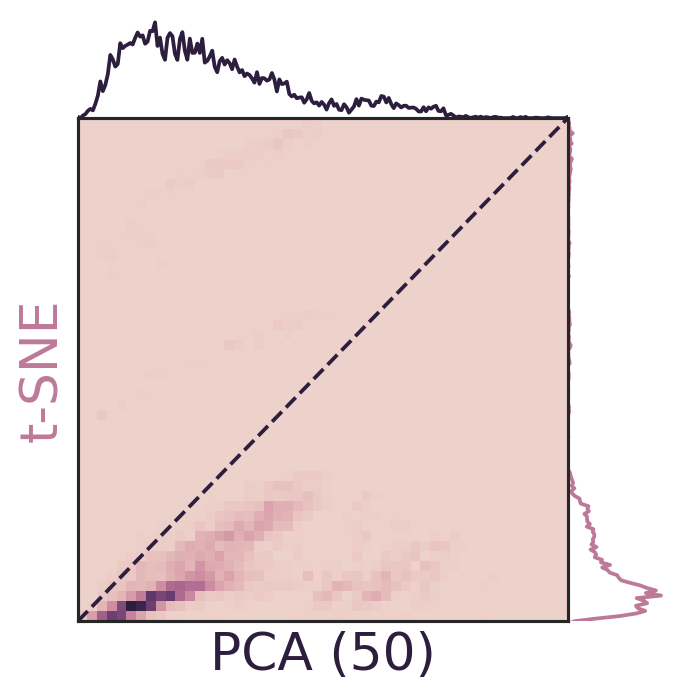

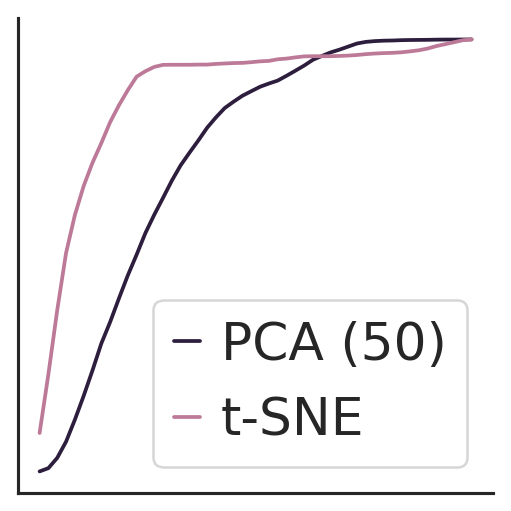

In [21]:
%%time
pca_dist_11, tsne_dist_11, corr_stats_11, EMD_11 = QCPipe.fcc.distance_stats(pre=adata.uns["X_pca_distances_11"], post=adata.uns["X_tsne_distances_11"])
print("\nR: {}\nEMD: {}".format(round(corr_stats_11[0],4), round(EMD_11,4)))
QCPipe.fcc.SP_plot(pre_norm=pca_dist_11, post_norm=tsne_dist_11, labels=["PCA (50)","t-SNE"], figsize=(4,4)).joint_plot_distance_correlation(save_to="figures/tsne_tuft_joint.png")
QCPipe.fcc.SP_plot(pre_norm=pca_dist_11, post_norm=tsne_dist_11, labels=["PCA (50)","t-SNE"], figsize=(3,3)).plot_cumulative_distributions(save_to="figures/tsne_tuft_dist.png")

Let's do the same for __UMAP__ to compare to __t-SNE__.

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions

R: 0.396
EMD: 0.0793
CPU times: user 1.74 s, sys: 478 ms, total: 2.22 s
Wall time: 1.71 s


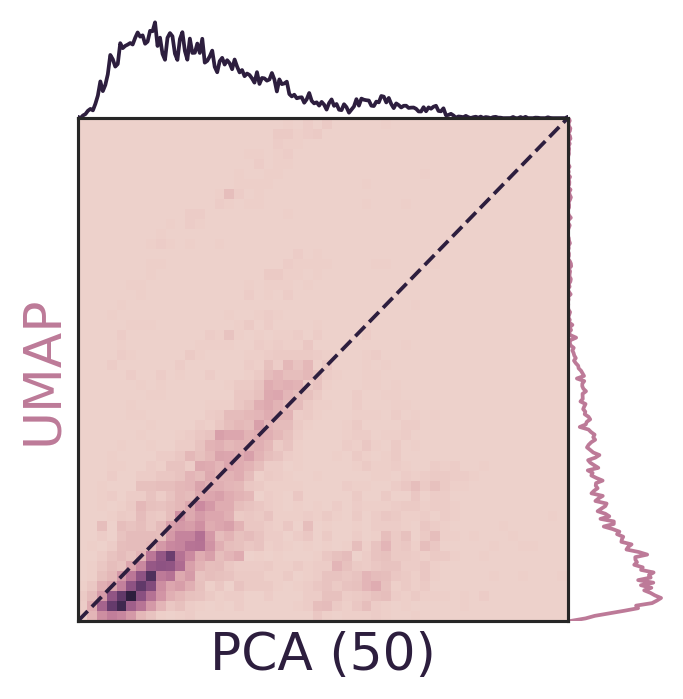

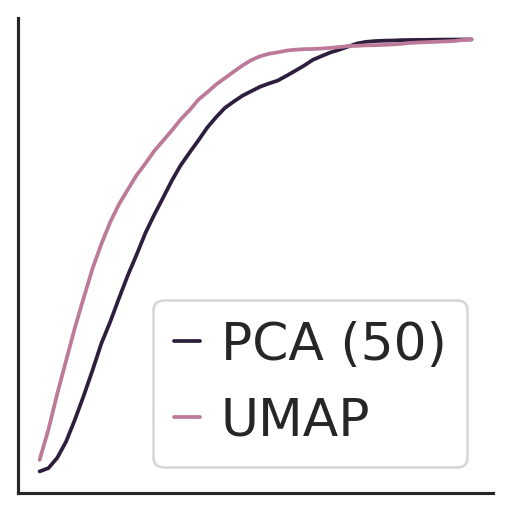

In [22]:
%%time
pca_dist_11, umap_dist_11, corr_stats_11, EMD_11 = QCPipe.fcc.distance_stats(pre=adata.uns["X_pca_distances_11"], post=adata.uns["X_umap_distances_11"])
print("\nR: {}\nEMD: {}".format(round(corr_stats_11[0],4), round(EMD_11,4)))
QCPipe.fcc.SP_plot(pre_norm=pca_dist_11, post_norm=umap_dist_11, labels=["PCA (50)","UMAP"], figsize=(4,4)).joint_plot_distance_correlation(save_to="figures/umap_tuft_joint.png")
QCPipe.fcc.SP_plot(pre_norm=pca_dist_11, post_norm=umap_dist_11, labels=["PCA (50)","UMAP"], figsize=(3,3)).plot_cumulative_distributions(save_to="figures/umap_tuft_dist.png")

---
### __3.8__ Neighborhood Preservation Analysis

We also have a nice wrapper function to compare the _pairwise distance distributions_ between cells in three clusters.  
Let's look at the __goblet cell lineage__ from stem to mature goblet cells (clusters "12","4", and "8") and plot them in each latent space.

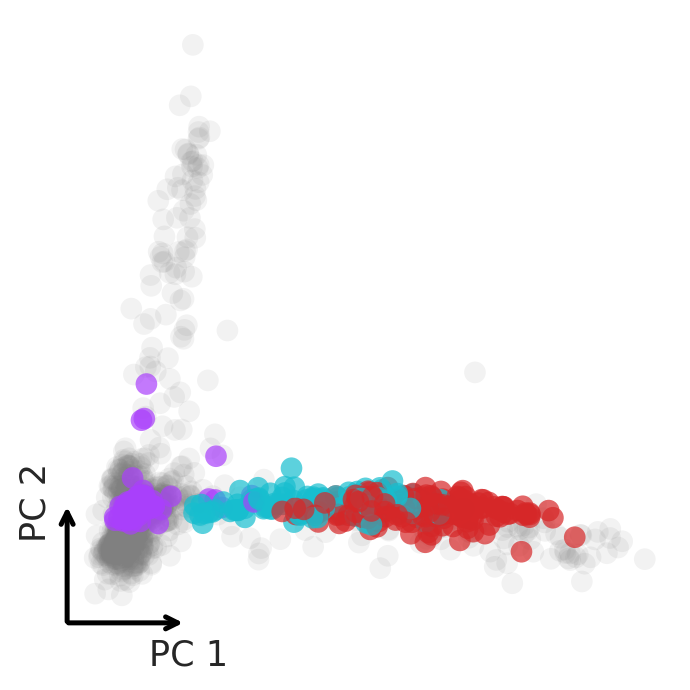

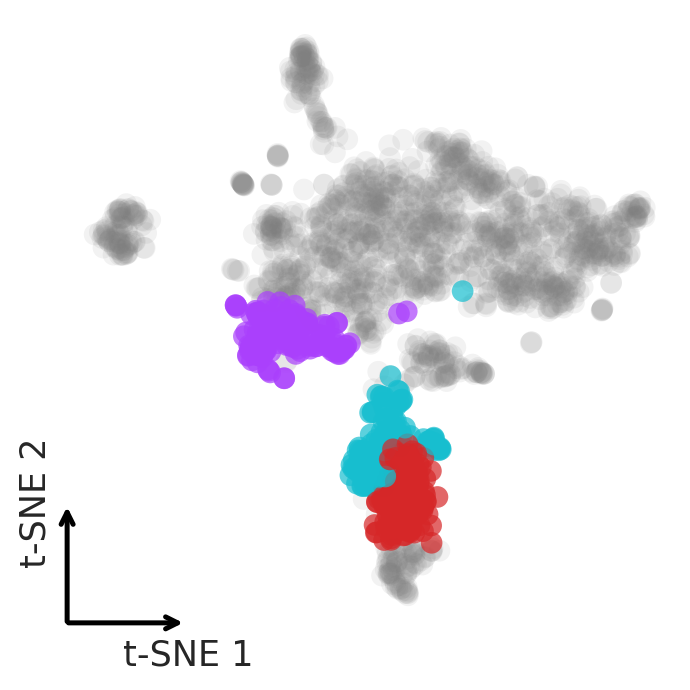

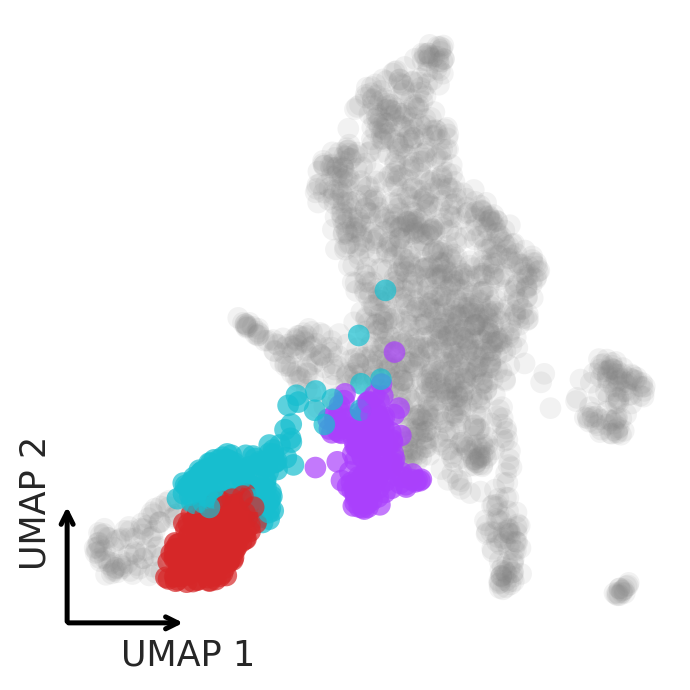

In [27]:
QCPipe.fcc.DR_plot(dim_name="PC", figsize=(4,4)).plot_IDs(adata=adata, use_rep="X_pca", obs_col="leiden", IDs=["4","3","8"], save_to="figures/pca_gobletlineage.png")
QCPipe.fcc.DR_plot(dim_name="t-SNE", figsize=(4,4)).plot_IDs(adata=adata, use_rep="X_tsne", obs_col="leiden", IDs=["4","3","8"], save_to="figures/tsne_gobletlineage.png")
QCPipe.fcc.DR_plot(dim_name="UMAP", figsize=(4,4)).plot_IDs(adata=adata, use_rep="X_umap", obs_col="leiden", IDs=["4","3","8"], save_to="figures/umap_gobletlineage.png")

Now run `cluster_arrangement_sc` to see how the local neighborhoods defined between substructures are altered in __t-SNE__ compared to __100-component PCA__.

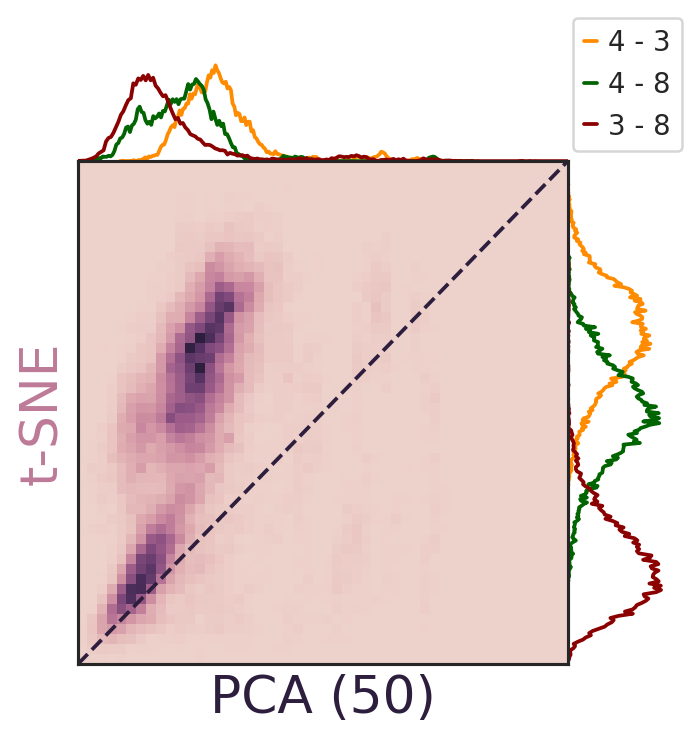

In [28]:
corr_tSNE, EMD_tSNE = QCPipe.fcc.cluster_arrangement_sc(
    adata=adata, 
    pre=adata.obsm["X_pca"], 
    post=adata.obsm["X_tsne"], 
    obs_col="leiden", IDs=["4","3","8"], 
    ax_labels=["PCA (50)","t-SNE"], 
    figsize=(4,4),
)
QCPipe.fcc.plt.savefig("figures/tsne_gobletlineage_joint.png")

We can do the same thing for __UMAP__.

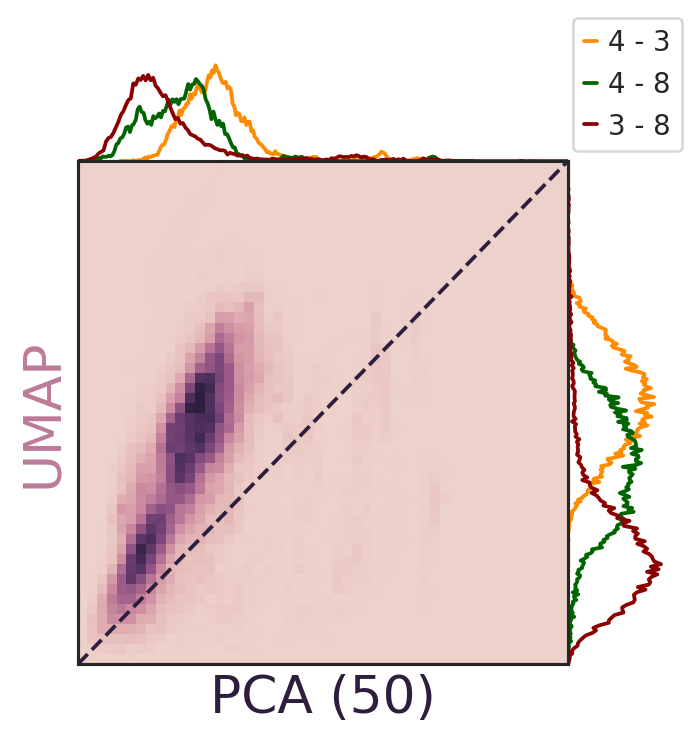

In [29]:
corr_UMAP, EMD_UMAP = QCPipe.fcc.cluster_arrangement_sc(
    adata=adata, 
    pre=adata.obsm["X_pca"], 
    post=adata.obsm["X_umap"], 
    obs_col="leiden", IDs=["4","3","8"], 
    ax_labels=["PCA (50)","UMAP"], 
    figsize=(4,4),
)
QCPipe.fcc.plt.savefig("figures/umap_gobletlineage_joint.png")

The correlation and EMD values _between_ each cluster are returned by the above function:

In [30]:
corr_tSNE

[0.26734859682046935, 0.25152708902466936, 0.3566473220948524]

In [31]:
EMD_tSNE

[0.36464354363392154, 0.2844803876866855, 0.03594657211262946]

In [32]:
corr_UMAP

[0.35187193072534023, 0.3992169891299251, 0.3024676976711355]

In [33]:
EMD_UMAP

[0.23339271627438482, 0.17612881084852403, 0.05592066061396809]

---
### __3.9__ Topological Cluster Preservation

Finally, to get an idea of the global arrangement of substructures relative to one another, we construct a minimum-spanning tree (MST) graph between cluster centroids in native and latent spaces.  
Permuted edges from one graph to another indicate rearrangement of cluster topology following dimension reduction.

In [34]:
QCPipe.fcc.find_centroids(adata, use_rep="X_pca", obs_col="leiden")
QCPipe.fcc.find_centroids(adata, use_rep="X_tsne", obs_col="leiden")
QCPipe.fcc.find_centroids(adata, use_rep="X_umap", obs_col="leiden")

The above function generates a `networkx` graph in `adata.uns['*_centroid_MST']`.  We can compare the `.edges` attribute of these graphs to determine which ones changed.  
Furthermore, we have a nice visualization function (`DR_plot().plot_centroids()`) to overlay the graph on our embeddings.

5 permuted edges from native space.


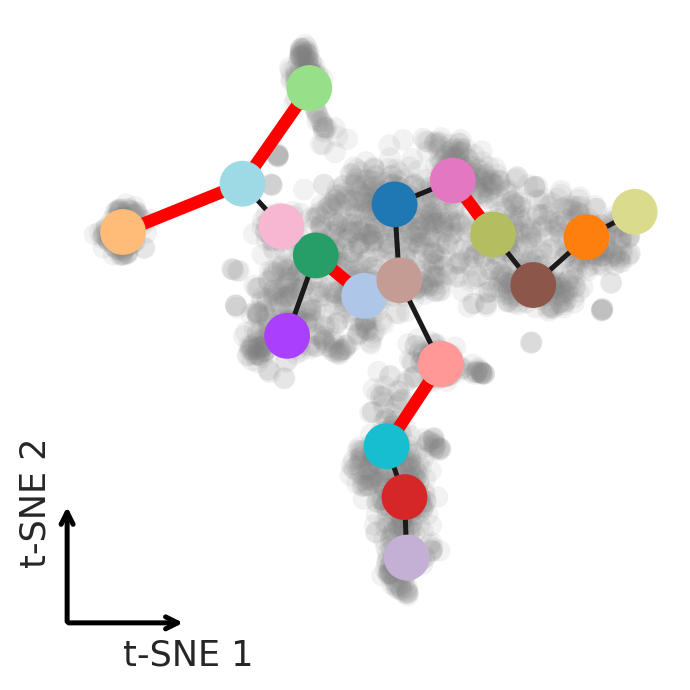

In [35]:
tsne_set = set(adata.uns["X_tsne_centroid_MST"].edges).difference(set(adata.uns["X_pca_centroid_MST"].edges))
print("{} permuted edges from native space.".format(len(tsne_set)))

QCPipe.fcc.DR_plot(dim_name="t-SNE", figsize=(4,4)).plot_centroids(adata=adata, obs_col="leiden", use_rep="X_tsne", highlight_edges=tsne_set, save_to="figures/tsne_MST.png")

3 permuted edges from native space.


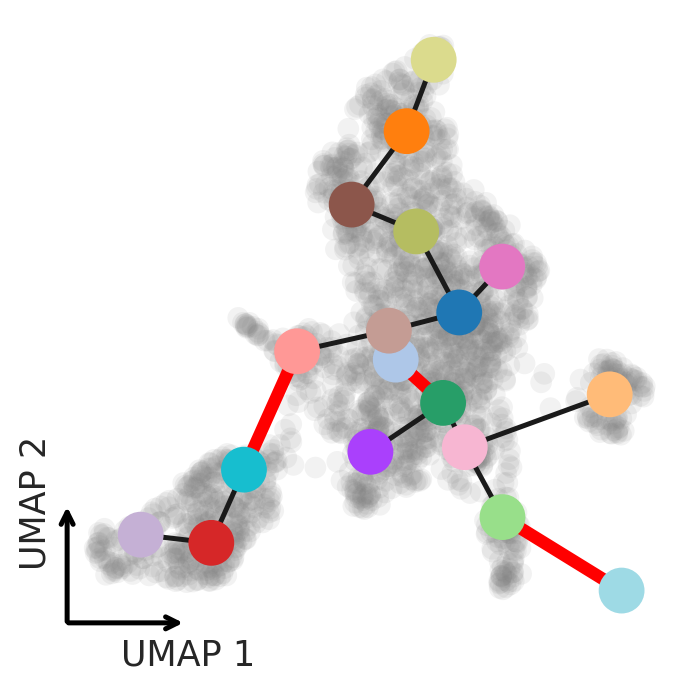

In [36]:
umap_set = set(adata.uns["X_umap_centroid_MST"].edges).difference(set(adata.uns["X_pca_centroid_MST"].edges))
print("{} permuted edges from native space.".format(len(umap_set)))

QCPipe.fcc.DR_plot(dim_name="UMAP", figsize=(4,4)).plot_centroids(adata=adata, obs_col="leiden", use_rep="X_umap", highlight_edges=umap_set, save_to="figures/umap_MST.png")